<h1>21st Century Suicide Data</h1>
Suicide – ending your life voluntarily takes 800,000 lives every year (accroding to WHO). It is the 10th biggest cause of death worldwide. 

This is my attempt to extrapolate the data set: Suicide in the 21st Century (http://bit.ly/SuicideDataWHO) to understand the various caused of suicide and observing historical trends in this tragic phenomenom.

<small>Disclaimer: Mereley using WHO's data, not associated with them in any way.</small>

<h2>Table of contents</h2>
* [Preliminaries](#preliminaries)
* [Basic facts about suicide](#basic_facts)
* [Operationalization](#operationalization)
* [Results](#results)
* [Conclusion](#conclusion)

<a id='preliminaries'></a>
<h2>Preliminaries</h2>
Let's make necessary imports. The dataset consists of the number of suicides each year in a given country, split by sex and age groups, plus the total population in according group, thus allowing us to calculate the **crude rates per 100k people**.
<p>The use of rates seems obvious, as the sheer number of suicides corresponds to the size of the population: the bigger the country, the more suicides. What is less obvious is that these rates - also called *crude rates* - do not allow for a proper comparison between countries. Suicide rates, as we shall see, vary considerably depending on demographic groups, so for a country as a whole one has to take into account its current demographic structure. This is why WHO uses age-standardized rates:
![](http://www.who.int/mental_health/suicide-prevention/Global_AS_suicide_rates_bothsexes_2016.png)    

The data looks good, apart from some missing values. For now, I make two transformations to sort and show age categories more conveniently.

In [1]:
# imports
import pandas as pd
import seaborn as sns

file = '../input/who_suicide_statistics.csv'
whoss_df = pd.read_csv(file)

# having 'years' in the age group seems unnecessary, and '05-14' will sort better than '5-14'
whoss_df.loc[:, 'age'] = whoss_df['age'].str.replace(' years','')
whoss_df.loc[whoss_df['age'] == '5-14', 'age'] = '05-14'

# crude rate calculation
whoss_df['crude_rate_per_100k'] = whoss_df['suicides_no'] / (whoss_df['population'] / 100000)

# preview
pd.concat([whoss_df[:2], whoss_df[10000:10002], whoss_df[-2:]])

,country,year,sex,age,suicides_no,population,crude_rate_per_100k
0,Albania,1985,female,15-24,NaN,277900.0,NaN
1,Albania,1985,female,25-34,NaN,246800.0,NaN
10000,Croatia,2007,female,55-74,84.0,533554.0,15.743486
10001,Croatia,2007,female,75+,45.0,204595.0,21.994672
43774,Zimbabwe,1990,male,55-74,74.0,NaN,NaN
43775,Zimbabwe,1990,male,75+,13.0,NaN,NaN


In [2]:
whoss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43776 entries, 0 to 43775
Data columns (total 7 columns):
country                43776 non-null object
year                   43776 non-null int64
sex                    43776 non-null object
age                    43776 non-null object
suicides_no            41520 non-null float64
population             38316 non-null float64
crude_rate_per_100k    36060 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 2.3+ MB


Out of 44k total records, we have 36k (that is 82% of the dataset) with the crude rate calculated and all other columns filled with values.

<a id='basic_facts'></a>
<h2>Basic facts about suicide</h2>
Before looking at how things change over time, we shall observe a few basic facts about suicide:
* Men are far more prone to commiting suicide than women, or at least this is what the data shows.
* Young people, adolescents in particular, are *NOT* at the greatest risk. See the charts below. These are only examples, but this general pattern comes up time and again.
* There are considerable differences between countries *even after* age standardization. Recall the WHO map above. 

Some part of the observed differences between countries and demographic groups may be explained by underreporting, biases and other issues with acknowledgment and classification of suicides.

<p>The charts below show crude suicide rates per 100k population in 2015.</p>

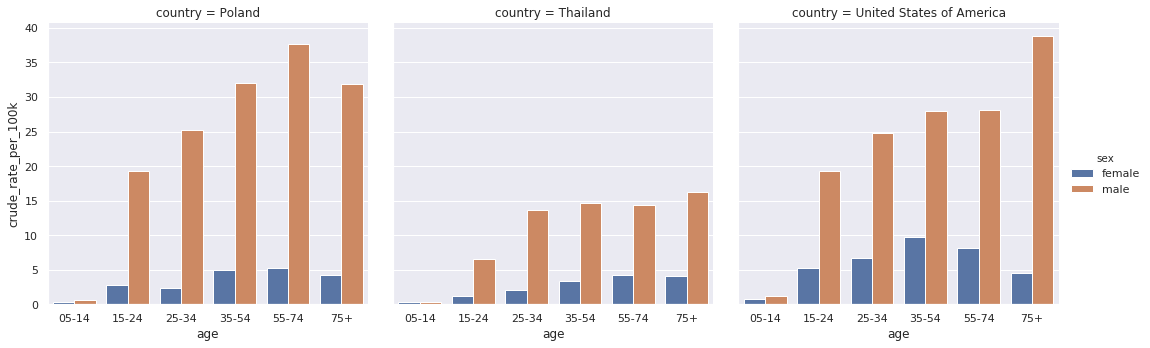

In [3]:
# seaborn settings reset
sns.set()

# chart data
cd = (whoss_df.loc[(whoss_df['country'].isin(['Poland','Thailand','United States of America'])) 
             & (whoss_df['year'] == 2015), ['country','sex','age','crude_rate_per_100k']]
      .sort_values(['sex','age']))

sns.catplot(x='age', hue='sex', col='country', y='crude_rate_per_100k'
            , data=cd, kind='bar', col_wrap=3)

<a id='operationalization'></a>
<h2>Operationalization</h2>
The core of my analysis is a comparison between the recent rates of suicide versus the beginning of the 21st century, which I define as the 1996-2005 period, while by 'recent' I mean the 2006-2015 decade. Furthermore, I use the median rate from at least five years in a decade as a representative for that decade. This way we should be protected from noise, that is, fluctuations between single years that may not capture significant changes in major factors and mechanisms responsible for suicides. Because there are big differences in suicide rates between demographic groups, the median rate is calculated for each country, sex and age group separately. 

In [4]:
# grouping into two decades of interest
whoss_df.loc[(whoss_df['year'] >= 1996) & (whoss_df['year'] <= 2005), 'decade'] = '1996-2005'
whoss_df.loc[(whoss_df['year'] >= 2006) & (whoss_df['year'] <= 2015), 'decade'] = '2006-2015'

# median of the crude rate in a decade, along with information about how many years of data are available
stats_by_decade_df = (whoss_df.groupby(['country','decade','sex','age'])['crude_rate_per_100k']
                      .agg(['median','count'])
                      .reset_index()
                     )

stats_by_decade_df.head()

,country,decade,sex,age,median,count
0,Albania,1996-2005,female,05-14,0.278641,10
1,Albania,1996-2005,female,15-24,5.317182,10
2,Albania,1996-2005,female,25-34,3.682569,10
3,Albania,1996-2005,female,35-54,2.452446,10
4,Albania,1996-2005,female,55-74,1.779099,10


In [7]:
# select only these cases where we have at least X years of data
valid_threshold = 5

# fraction_above_threshold = sum(stats_by_decade_df['count'] >= valid_threshold) / len(stats_by_decade_df)
# print('There are {0:.1%} rows with at least {1} years of data.'
#       .format(fraction_above_threshold, valid_threshold))

**To evaluate whether things are going in a positive direction or not, I compare median suicide rate in 2006-2015 versus 1996-2005.**

To make the charts more concise, I am capping that difference at +/-20 (per 100k population). It is not necessary, and it does not affect the following results and conclusions, it just makes the charts nicer. 

A preview of the resulting table, seen below, helps understand how the rate difference is calculated. For example, in Albania, among women aged 25-34 the median suicide rate in 1996-2005 was 3.68 (`median_d1`) while in 2006-2015 it was 3.27 (`median_d2`), which gives a difference of -0.41 (`crude_rate_diff`).

In [8]:
# difference in median of crude rates between two decades
# perhaps there is a better way to calculate this, instead of doing two calculations and joining them into one table
d1_df = stats_by_decade_df[(stats_by_decade_df['decade'] == '1996-2005') & (stats_by_decade_df['count'] >= valid_threshold)]
d2_df = stats_by_decade_df[(stats_by_decade_df['decade'] == '2006-2015') & (stats_by_decade_df['count'] >= valid_threshold)]

final_df = d1_df.merge(d2_df, left_on=['country','sex','age'], 
            right_on=['country','sex','age'], how='inner',
           suffixes=['_d1','_d2'])
           
final_df['crude_rate_diff'] = final_df['median_d2'] - final_df['median_d1']

# capping on crude rates difference
final_df.loc[final_df['crude_rate_diff'] > 20, 'crude_rate_diff'] = 20
final_df.loc[final_df['crude_rate_diff'] < -20, 'crude_rate_diff'] = -20

print('There are', final_df['country'].nunique(), 'countries with at least', valid_threshold, 'years of data.')
final_df.head()

There are 93 countries with at least 5 years of data.


,country,decade_d1,sex,age,median_d1,count_d1,decade_d2,median_d2,count_d2,crude_rate_diff
0,Albania,1996-2005,female,05-14,0.278641,10,2006-2015,0.000000,5,-0.278641
1,Albania,1996-2005,female,15-24,5.317182,10,2006-2015,2.276340,5,-3.040842
2,Albania,1996-2005,female,25-34,3.682569,10,2006-2015,3.268348,5,-0.414221
3,Albania,1996-2005,female,35-54,2.452446,10,2006-2015,3.041108,5,0.588662
4,Albania,1996-2005,female,55-74,1.779099,10,2006-2015,2.898659,5,1.119560


<a id='results'></a>
<h2>Results</h2>

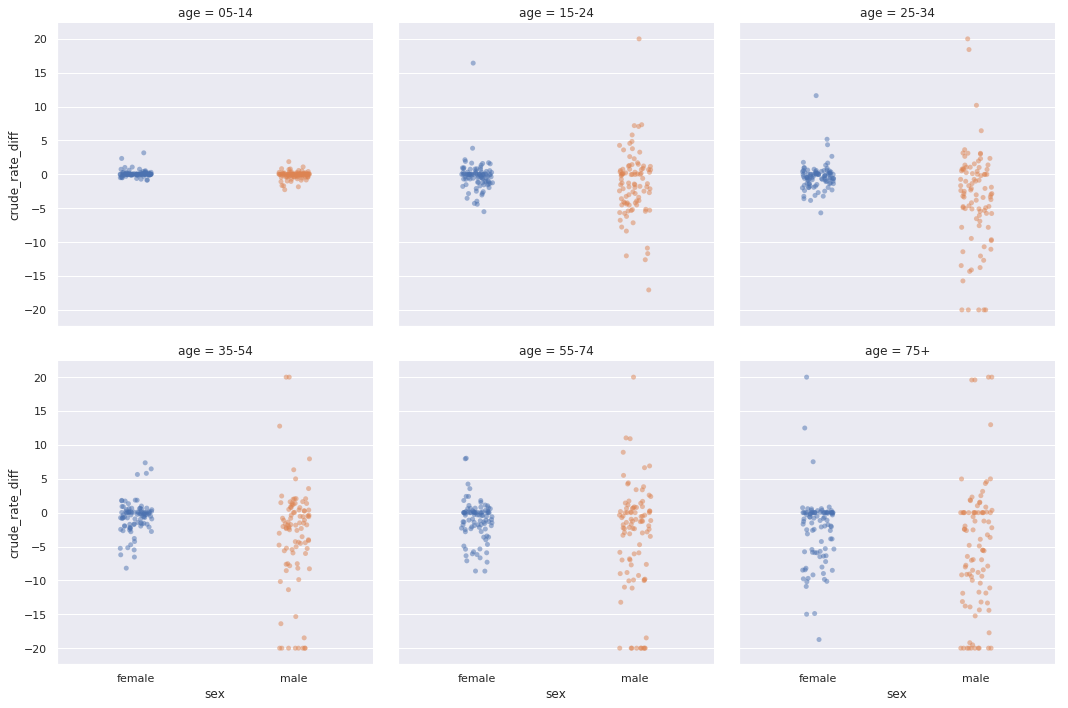

In [9]:
sns.catplot(x='sex', y="crude_rate_diff", col="age", col_wrap=3, sharey=True, data=final_df, alpha=0.5)

Before starting this analysis, I was prepared to see an increase in suicide rates across sexes and age groups. I can now honestly say I am happy that I was wrong. Sure, there are countries which indeed saw an increase in suicides per capita in a given demographic group, and a few of these surges are dramatic. More often than not, however, **we see a positive change, concerning many countries, all age groups above 15, and especially men** (the reason why we don't see a huge improvement among women is that women already had relatively low suicide rates to begin with). The vast majority of the dots are either near zero (meaning no change) or below zero (meaning fewer deaths per capita than in the previous decade).

To quantify that notion, I put these results into three broad categories:
* Increase in suicide rates. The difference between the median suicide rates in 2006-2015 versus 1996-2005 is positive and greater than (or equal to) a given threshold, which I set at 2 per 100k population.
* No change. The difference is smaller than the threshold, either way (negative or positive).
* Decrease in suicide rates.

The charts below confirm the positive change that is happening - the green bars are much higher than the brown(ish) ones.


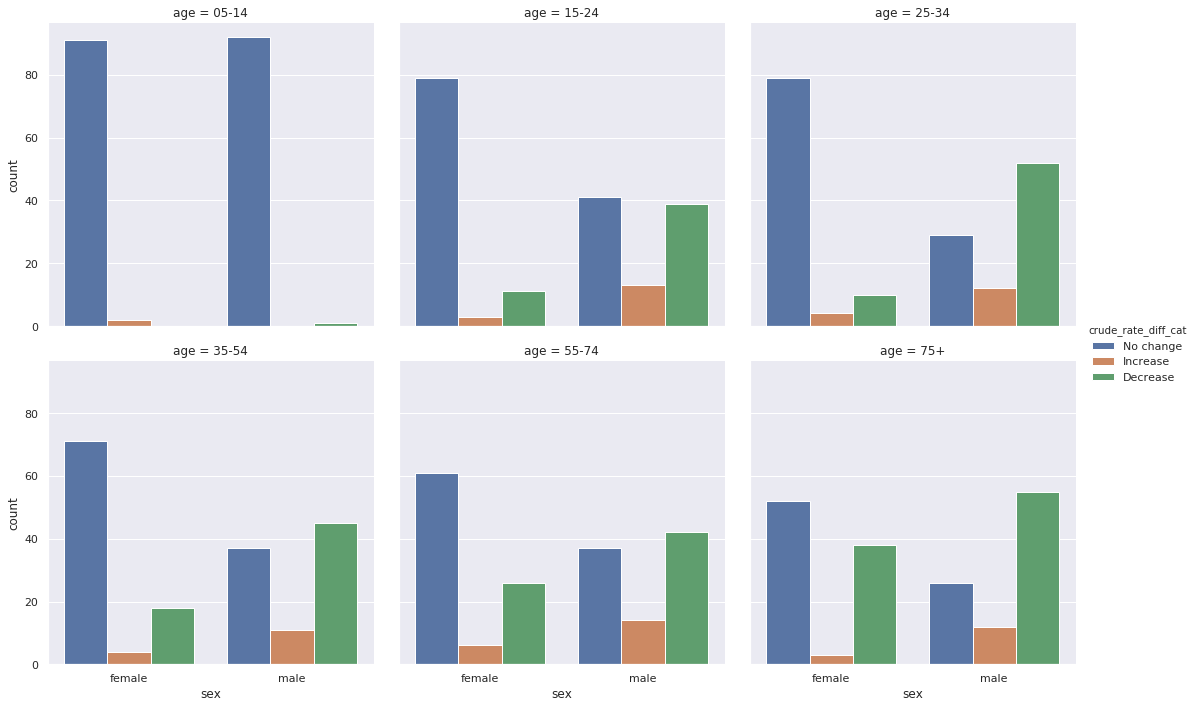

In [10]:
# decide what qualifies as change (increase or decrease)
def categorize_differences(x, threshold):
    if (x <= -threshold):
        diff_category = 'Decrease'
    elif (x >= threshold):
        diff_category = 'Increase'
    else:
        diff_category = 'No change'
    
    return diff_category
        
final_df['crude_rate_diff_cat'] = final_df['crude_rate_diff'].map(lambda x: categorize_differences(x, 2))

# results
sns.catplot(x='sex', hue='crude_rate_diff_cat', col='age', col_wrap=3, 
            data=final_df.sort_values(['age','crude_rate_diff_cat','sex'], ascending=[True,False,True]), 
            kind='count')

<a id='conclusion'></a>
<h2>Conclusion and invitation to discussion</h2>
My question was: is it getting better or worse? And the answer is: **it is getting better**, at least in the data. Suicide rates have generally declined. **During the 2006-2015 decade, many countries saw their suicide rates decrease, compared to the 1996-2005 period. This trend is visible in virtually all broad age categories in both sexes**. The use of median suicide rate as representative of a decade (for a given country, age and gender) minimizes the risk that the observed effect is spurious due to randomness. I wish to all of us that this trend continues throughout the whole 21st century.

As for the reasons behind the observed change, there are many possibilities, which I would describe in broad strokes as follows:
1. Mechanisms - intended or not - that make commiting suicide harder.
2. Real sociological, psychological etc. factors keeping people away from thinking about suicide in the first place.
3. Mistakes, biases, changes of methodology, or fraud, beginning with data collection at the local level.
4. An error in my procedure of data extraction, processing or analysis.